In [1]:
import boto3
import pandas as pd
from io import StringIO # encode data into binary format
import configparser
import time
config = configparser.ConfigParser()
config.read_file(open('cluster.config'))
config

In [42]:
AWS_ACCESS_KEY             = config.get('AWS','KEY')
AWS_SECRET_KEY             = config.get('AWS','SECRET')
AWS_REGION                 = config.get('AWS', 'REGION')
SCHEMA_NAME                = "covid_19"    # Database name in the athena
S3_STAGING_DIR             = "s3://parham-test-bucket-26092023/output"
S3_BUCKET_NAME             = "parham-test-bucket-26092023"
S3_OUTPUT_DIRECTORY        = "output"

In [3]:
# connect athena and query data
athena_client = boto3.client(
    "athena",
    aws_access_key_id = AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name= AWS_REGION
)

In [9]:
Dict = {}
def download_and_load_query_results(
        client:boto3.client,query_response: Dict
) -> pd.DataFrame:
    while True:
        try:
            # This function only loads the first 1000 rows
            client.get_query_results(
                QueryExecutionId= query_response["QueryExecutionId"]
            )
            break
        except Exception as e:
            if "not yet finished" in str(e):
                time.sleep(0.001)
            else:
                raise e
    temp_file_location: str = "athena_query_results.csv"
    s3_client = boto3.client(
        "s3",
        aws_access_key_id = AWS_ACCESS_KEY,
        aws_secret_access_key=AWS_SECRET_KEY,
        region_name= AWS_REGION
    )
    s3_client.download_file(
        S3_BUCKET_NAME,
        f"{S3_OUTPUT_DIRECTORY}/{query_response['QueryExecutionId']}.csv",
        temp_file_location
    )
    return pd.read_csv(temp_file_location)

### Make some query on Datasets

In [24]:

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM enigma_jhud",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },                                                
)
response

{'QueryExecutionId': '44077315-c5f6-4113-926e-ee7f06991b27',
 'ResponseMetadata': {'RequestId': '45f1f493-7f68-44f1-b862-323261e9d589',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 27 Sep 2023 22:13:12 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '59',
   'connection': 'keep-alive',
   'x-amzn-requestid': '45f1f493-7f68-44f1-b862-323261e9d589'},
  'RetryAttempts': 0}}

In [25]:
# enigma
enigma_jhud = download_and_load_query_results(athena_client,response)
enigma_jhud.head()

,fips,admin2,province_state,country_region,last_update,latitude,longitude,confirmed,deaths,recovered,active,combined_key,partition_0
0,NaN,NaN,Anhui,China,2020-01-22T17:00:00,31.826,117.226,1.0,NaN,NaN,NaN,"""Anhui",csv
1,NaN,NaN,Beijing,China,2020-01-22T17:00:00,40.182,116.414,14.0,NaN,NaN,NaN,"""Beijing",csv
2,NaN,NaN,Chongqing,China,2020-01-22T17:00:00,30.057,107.874,6.0,NaN,NaN,NaN,"""Chongqing",csv
3,NaN,NaN,Fujian,China,2020-01-22T17:00:00,26.079,117.987,1.0,NaN,NaN,NaN,"""Fujian",csv
4,NaN,NaN,Gansu,China,2020-01-22T17:00:00,36.061,103.834,NaN,NaN,NaN,NaN,"""Gansu",csv


In [11]:
# nytimes data
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM nytimes_data_in_usa_us_county",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
nytimes_data_in_usa_us_county = download_and_load_query_results(athena_client,response)

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM nytimes_data_in_usa_us_states",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
nytimes_data_in_usa_us_states = download_and_load_query_results(athena_client,response)


In [32]:
# rearc data
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM rearc_covid_19_testing_data_states_dailystates_daily",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
rearc_covid_19_testing_data_states_dailystates_daily = download_and_load_query_results(athena_client,response)

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM rearc_covid_19_testing_data_us_total_latest",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
rearc_covid_19_testing_data_us_total_latest = download_and_load_query_results(athena_client,response)

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM rearc_covid_19_testing_dataus_daily",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
rearc_covid_19_testing_dataus_daily = download_and_load_query_results(athena_client,response)

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM rearc_usa_hospital_beds",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
rearc_usa_hospital_beds = download_and_load_query_results(athena_client,response)


In [13]:
# static data
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM static_data_countrycode",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
static_data_countrycode = download_and_load_query_results(athena_client,response)

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM static_data_countypopulation",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
static_data_countypopulation = download_and_load_query_results(athena_client,response)

response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM static_data_state_abv",
    QueryExecutionContext={"Database":SCHEMA_NAME},
    ResultConfiguration={
        "OutputLocation":S3_STAGING_DIR,
        "EncryptionConfiguration":{"EncryptionOption":"SSE_S3"}
    },)   
static_data_state_abv = download_and_load_query_results(athena_client,response)
static_data_state_abv.head()


,col0,col1
0,State,Abbreviation
1,Alabama,AL
2,Alaska,AK
3,Arizona,AZ
4,Arkansas,AR


##### As we can see the column names are not correct and we must replace ot with the record 0

In [14]:
new_header = static_data_state_abv.iloc[0]
static_data_state_abv, static_data_state_abv.columns = static_data_state_abv[1:],new_header
static_data_state_abv.head()

,State,Abbreviation
1,Alabama,AL
2,Alaska,AK
3,Arizona,AZ
4,Arkansas,AR
5,California,CA


# ETL Pipeline based on fact tabel provided as bellow:
![model dimention.png](<attachment:model dimention.png>)
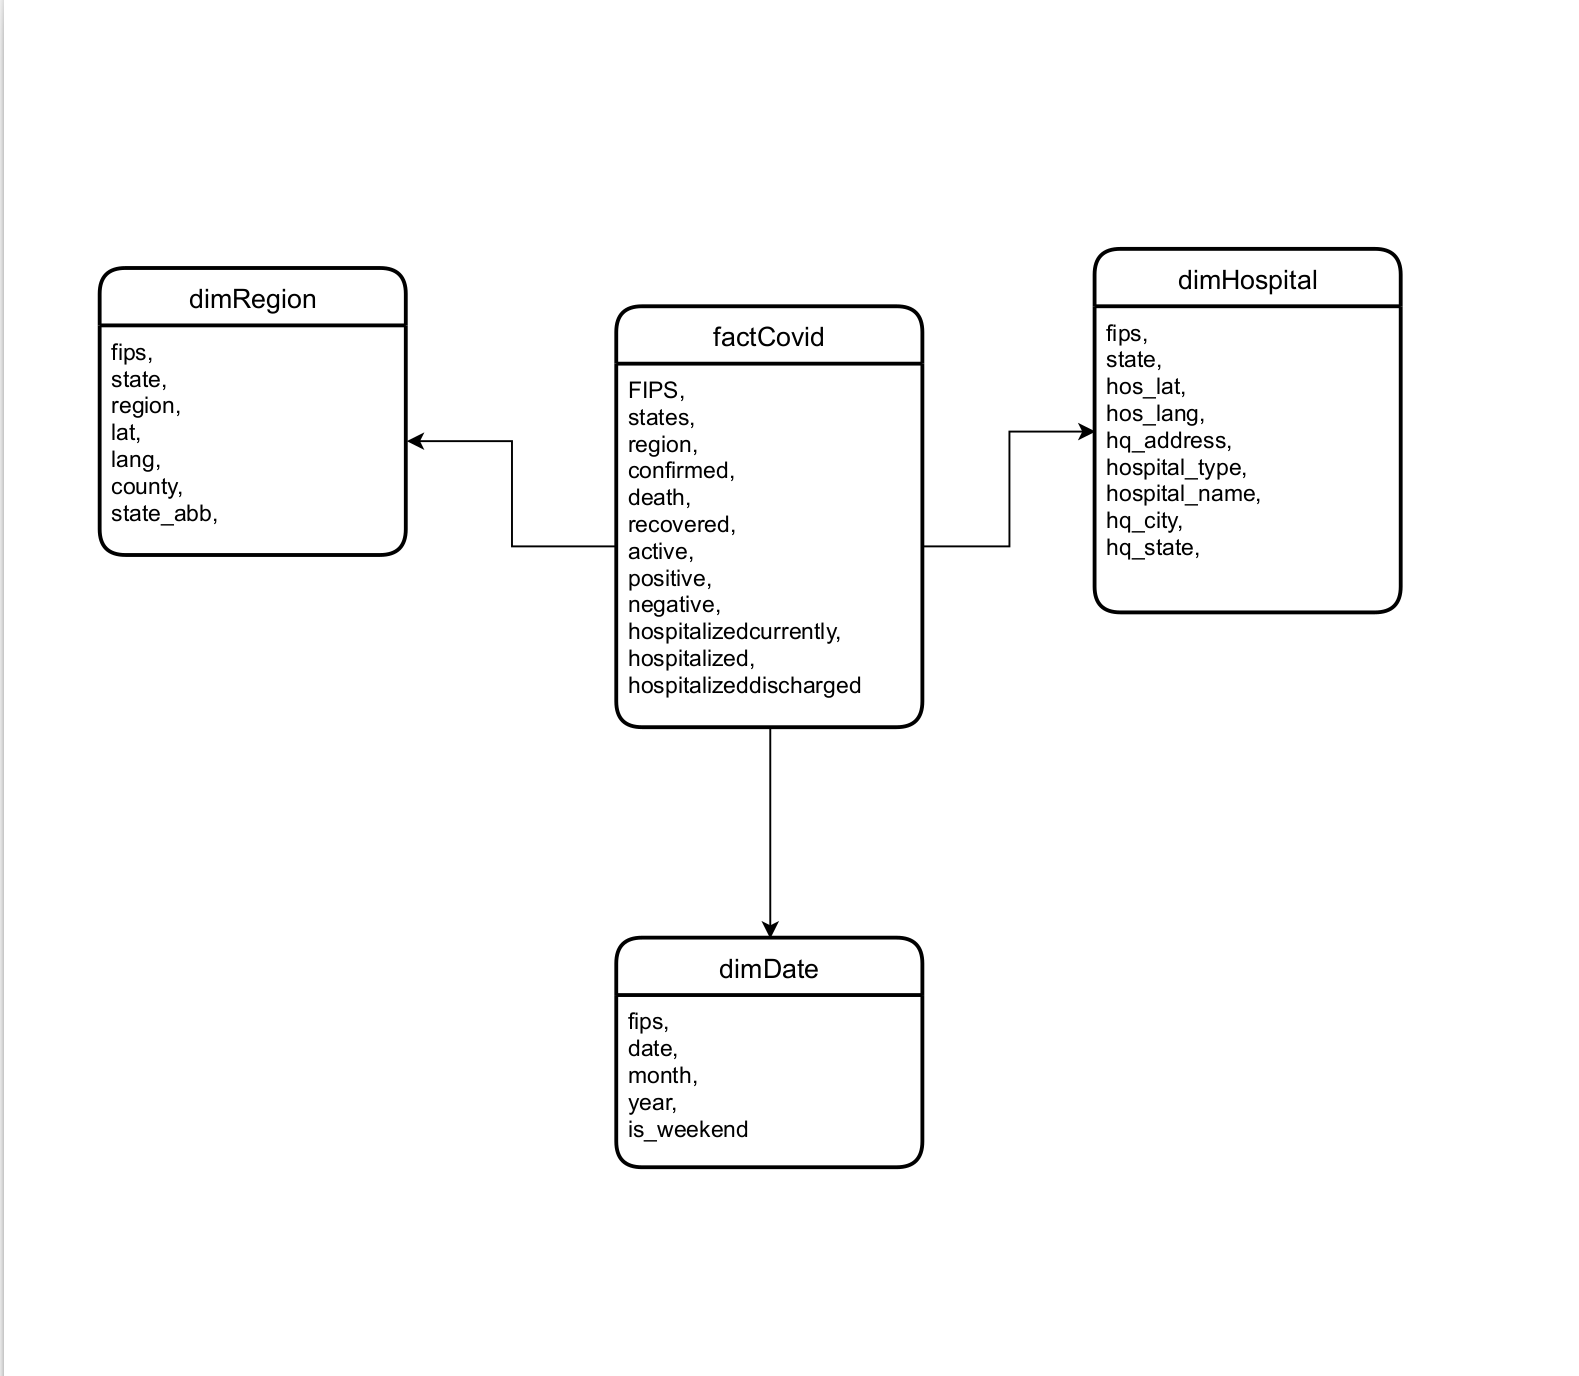

### Create Dimension Table

In [21]:
enigma_jhud['fips']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
222799   NaN
222800   NaN
222801   NaN
222802   NaN
222803   NaN
Name: fips, Length: 222804, dtype: float64

In [29]:
factCovid_1 = enigma_jhud[['fips','province_state','country_region','confirmed','deaths',
                          'recovered','active']]
factCovid_2 = rearc_covid_19_testing_data_states_dailystates_daily[['fips','date','positive','negative','hospitalizedcurrently','hospitalized','hospitalizeddischarged']]
factCovid = pd.merge(factCovid_1,factCovid_2,on='fips',how='inner')
print(factCovid.shape)
factCovid[factCovid['fips']>0].head()

(27992, 13)


,fips,province_state,country_region,confirmed,deaths,recovered,active,date,positive,negative,hospitalizedcurrently,hospitalized,hospitalizeddischarged
24440,72.0,Puerto Rico,US,3.0,0.0,0.0,NaN,20210307,101327,305972.0,147.0,NaN,NaN
24441,72.0,Puerto Rico,US,3.0,0.0,0.0,NaN,20210306,101327,305972.0,147.0,NaN,NaN
24442,72.0,Puerto Rico,US,3.0,0.0,0.0,NaN,20210305,101066,305972.0,136.0,NaN,NaN
24443,72.0,Puerto Rico,US,3.0,0.0,0.0,NaN,20210304,100867,305972.0,171.0,NaN,NaN
24444,72.0,Puerto Rico,US,3.0,0.0,0.0,NaN,20210303,100765,305972.0,169.0,NaN,NaN


In [48]:
dimRegion_1 = enigma_jhud[['fips','province_state','country_region','latitude','longitude']]
dimRegion_2 = nytimes_data_in_usa_us_county[['fips','county','state']]
dimRegion = pd.merge(factCovid_1,factCovid_2,on='fips',how='inner')

In [33]:
rearc_usa_hospital_beds.columns

Index(['objectid', 'hospital_name', 'hospital_type', 'hq_address',
       'hq_address1', 'hq_city', 'hq_state', 'hq_zip_code', 'county_name',
       'state_name', 'state_fips', 'cnty_fips', 'fips', 'num_licensed_beds',
       'num_staffed_beds', 'num_icu_beds', 'adult_icu_beds', 'pedi_icu_beds',
       'bed_utilization', 'avg_ventilator_usage',
       'potential_increase_in_bed_capac', 'latitude', 'longtitude'],
      dtype='object')

In [51]:
dimHospital = rearc_usa_hospital_beds[['fips','state_name','latitude','longtitude','hq_address',
                                       'hospital_type','hospital_name','hq_city', 'hq_state']]

In [36]:
dimDate = rearc_covid_19_testing_data_states_dailystates_daily[['fips','date']]
dimDate['date'] = pd.to_datetime(dimDate['date'],format='%Y%m%d')
dimDate['year'] = dimDate['date'].dt.year
dimDate['month'] = dimDate['date'].dt.month
dimDate['day_of_week'] = dimDate['date'].dt.day_of_week
dimDate.head()


/tmp/ipykernel_3688/1089364521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimDate['date'] = pd.to_datetime(dimDate['date'],format='%Y%m%d')
/tmp/ipykernel_3688/1089364521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimDate['year'] = dimDate['date'].dt.year
/tmp/ipykernel_3688/1089364521.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,fips,date,year,month,day_of_week
0,2.0,2021-03-07,2021,3,6
1,1.0,2021-03-07,2021,3,6
2,5.0,2021-03-07,2021,3,6
3,60.0,2021-03-07,2021,3,6
4,4.0,2021-03-07,2021,3,6


In [39]:
bucket = "parham-covid-de-project"

In [44]:
# save factCovid to S3 
csv_buffer = StringIO()
factCovid.to_csv(csv_buffer)
s3_source = boto3.resource('s3',
                           aws_access_key_id = AWS_ACCESS_KEY,
                           aws_secret_access_key=AWS_SECRET_KEY,
                           region_name= AWS_REGION)
s3_source.Object(bucket,"output/factCovid.csv").put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '7EWDGS8N3KW9QZB4',
  'HostId': 'KDHyxbb/BQbCJ6VzOlSofPqGSFyPErWvn0QfKUAZhZLS5mSKoxHoqVxBusiXFj5MxXRa0rR7k6I=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KDHyxbb/BQbCJ6VzOlSofPqGSFyPErWvn0QfKUAZhZLS5mSKoxHoqVxBusiXFj5MxXRa0rR7k6I=',
   'x-amz-request-id': '7EWDGS8N3KW9QZB4',
   'date': 'Wed, 27 Sep 2023 23:08:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"17f921c4aaa328789864c1da79f4e138"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"17f921c4aaa328789864c1da79f4e138"',
 'ServerSideEncryption': 'AES256'}

In [52]:
# save dimRegion to S3 
csv_buffer = StringIO()
dimRegion.to_csv(csv_buffer)
s3_source = boto3.resource('s3',
                           aws_access_key_id = AWS_ACCESS_KEY,
                           aws_secret_access_key=AWS_SECRET_KEY,
                           region_name= AWS_REGION)
s3_source.Object(bucket,"output/dimRegion.csv").put(Body=csv_buffer.getvalue())
# save dimHospital  to S3 
csv_buffer = StringIO()
dimHospital.to_csv(csv_buffer)
s3_source = boto3.resource('s3',
                           aws_access_key_id = AWS_ACCESS_KEY,
                           aws_secret_access_key=AWS_SECRET_KEY,
                           region_name= AWS_REGION)
s3_source.Object(bucket,"output/dimHospital.csv").put(Body=csv_buffer.getvalue())
# save dimDate  to S3 
csv_buffer = StringIO()
dimDate.to_csv(csv_buffer)
s3_source = boto3.resource('s3',
                           aws_access_key_id = AWS_ACCESS_KEY,
                           aws_secret_access_key=AWS_SECRET_KEY,
                           region_name= AWS_REGION)
s3_source.Object(bucket,"output/dimDate.csv").put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'J7ER1B65B13J1RTN',
  'HostId': 'iRmfVy6/NY0+ACAcXEAFsheYDaBihU6CI4LPoouhYQwuCOkUnQR1nV5R7xQWL/O4XXZ1BEqEaHg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'iRmfVy6/NY0+ACAcXEAFsheYDaBihU6CI4LPoouhYQwuCOkUnQR1nV5R7xQWL/O4XXZ1BEqEaHg=',
   'x-amz-request-id': 'J7ER1B65B13J1RTN',
   'date': 'Wed, 27 Sep 2023 23:14:22 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"c806953ef77c6fc33fdf78f5d2b636e4"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c806953ef77c6fc33fdf78f5d2b636e4"',
 'ServerSideEncryption': 'AES256'}

#### Now we must deploy on AWS Glue 

We need to extract the schema from out of these data and build table onto Redshift then we can\
 write copy command to load that data and then do some analysis on top of it.

In [53]:
dimDatesql = pd.io.sql.get_schema(dimDate.reset_index(),'dimDate')
print(''.join(dimDatesql))

CREATE TABLE "dimDate" (
"index" INTEGER,
  "fips" REAL,
  "date" TIMESTAMP,
  "year" INTEGER,
  "month" INTEGER,
  "day_of_week" INTEGER
)


In [54]:
factCovidsql = pd.io.sql.get_schema(factCovid.reset_index(),'factCovid')
print(''.join(factCovidsql))

CREATE TABLE "factCovid" (
"index" INTEGER,
  "fips" REAL,
  "province_state" TEXT,
  "country_region" TEXT,
  "confirmed" REAL,
  "deaths" REAL,
  "recovered" REAL,
  "active" REAL,
  "date" INTEGER,
  "positive" INTEGER,
  "negative" REAL,
  "hospitalizedcurrently" REAL,
  "hospitalized" REAL,
  "hospitalizeddischarged" REAL
)


In [55]:
dimRegionsql = pd.io.sql.get_schema(dimRegion.reset_index(),'dimRegion')
print(''.join(dimRegionsql))

CREATE TABLE "dimRegion" (
"index" INTEGER,
  "fips" REAL,
  "province_state" TEXT,
  "country_region" TEXT,
  "confirmed" REAL,
  "deaths" REAL,
  "recovered" REAL,
  "active" REAL,
  "date" INTEGER,
  "positive" INTEGER,
  "negative" REAL,
  "hospitalizedcurrently" REAL,
  "hospitalized" REAL,
  "hospitalizeddischarged" REAL
)


In [56]:
dimHospitalsql = pd.io.sql.get_schema(dimHospital.reset_index(),'dimHospital')
print(''.join(dimHospitalsql))

CREATE TABLE "dimHospital" (
"index" INTEGER,
  "fips" REAL,
  "state_name" TEXT,
  "latitude" REAL,
  "longtitude" REAL,
  "hq_address" TEXT,
  "hospital_type" TEXT,
  "hospital_name" TEXT,
  "hq_city" TEXT,
  "hq_state" TEXT
)


#### Create Redshift cluster

In [60]:
DWH_CLUSTER_TYPE        = config.get('DWH','DWH_CLUSTER_TYPE')
DWH_NUM_NODES           = config.get('DWH','DWH_NUM_NODES')
DWH_NODE_TYPE           = config.get('DWH','DWH_NODE_TYPE')
DWH_CLUSTER_IDENTIFIER  = config.get('DWH','DWH_CLUSTER_IDENTIFIER')
DWH_DB                  = config.get('DWH','DWH_DB')
DWH_DB_USER             = config.get('DWH','DWH_DB_USER')
DWH_DB_PASSWORD         = config.get('DWH','DWH_DB_PASSWORD')
DWH_PORT                = config.get('DWH','DWH_PORT')
DWH_IAM_ROLE_NAME       = config.get('DWH','DWH_IAM_ROLE_NAME')


iam = boto3.client(
    'iam',
    region_name = AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)
redshift = boto3.client(
    'redshift',
    region_name = AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)
ec2 = boto3.resource(
    'ec2',
    region_name = "eu-central-1",
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

# create redshift cluster
try:
    response = redshift.create_cluster(
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        #identifier and credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,
        # Roles for s3 access
        IamRoles=[roleArn]
    )

except Exception as e:
    print(e)

In [63]:
myClusterProps =redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
# create vpc
try:
    vpc=ec2.VPC(id=myClusterProps['VpcId'])
    defultSg=list(vpc.security_groups.all())[0]
    print(defultSg)
    defultSg.authorize_ingress(
        GroupName = defultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort= int(DWH_PORT),
        ToPort= int(DWH_PORT)
    )
except Exception as e:
    print(e)

'ec2.ServiceResource' object has no attribute 'VPC'


In [72]:
# connect to Redshift
import redshift_connector

DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
try:
    conn = redshift_connector.connect(
        host=DWH_ENDPOINT,
        database=DWH_DB,
        user=DWH_DB_USER,
        password=DWH_DB_PASSWORD
    )
    
except redshift_connector.Error as e:
    print("Error: Couldn't make connection to the Postgres database")
    print(e)

conn.autocommit = True

In [75]:
# create cursure to execute query on Redshift or database
try:
    cursor = conn.cursor()
except redshift_connector.Error as e:
    print("Error: Couldn't get cursur to the Database")
    print(e)

### Do some queries on Redshift cluster

In [86]:
cursor.execute("""
CREATE TABLE "dimDate" (
"index" INTEGER,
  "fips" REAL,
  "date" TIMESTAMP,
  "year" INTEGER,
  "month" INTEGER,
  "day_of_week" INTEGER
);
""")

In [80]:
# same things for other tabels with different method
cursor.execute(''.join(factCovidsql))
cursor.execute(''.join(dimRegionsql))
cursor.execute(''.join(dimHospitalsql))

In [87]:
# use copy command to copy data from s3 to redshift
cursor.execute("""
                copy dimDate from 's3://parham-covid-de-project/output/dimDate.csv'
                credentials 'aws_iam_role=arn:aws:iam::865994740931:role/parham'
                delimiter ','
                region 'eu-central-1'
               IGNOREHEADER 1
""")

cursor.execute("""
                copy dimHospital from 's3://parham-covid-de-project/output/dimHospital.csv'
                credentials 'aws_iam_role=arn:aws:iam::865994740931:role/parham'
                delimiter ','
                region 'eu-central-1'
               IGNOREHEADER 1
""")

cursor.execute("""
                copy dimRegion from 's3://parham-covid-de-project/output/dimRegion.csv'
                credentials 'aws_iam_role=arn:aws:iam::865994740931:role/parham'
                delimiter ','
                region 'eu-central-1'
               IGNOREHEADER 1
""")

cursor.execute("""
                copy factCovid from 's3://parham-covid-de-project/output/factCovid.csv'
                credentials 'aws_iam_role=arn:aws:iam::865994740931:role/parham'
                delimiter ','
                region 'eu-central-1'
               IGNOREHEADER 1
""")